# Research question 6



### Do budget and production scale affect the type of ending chosen? Exploring whether high-budget films tend to favor certain endings (e.g., happy endings for wider audience appeal) could reveal if financial considerations impact storytelling choices.

This notebook presents initial observations and is not intended to represent the final conclusions.


##### Importations

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from dash import Dash, html, dcc
from dash.dependencies import Input, Output
import plotly.graph_objects as go
from matplotlib import cm
import numpy as np
import plotly.express as px
import ast
from scipy.stats import shapiro, levene, f_oneway, kruskal
import networkx as nx
import scikit_posthocs as sp
import plotly.io as pio



copper_colormap = cm.get_cmap('copper', 256)  # 256 niveaux
copper_colorscale = [
    [i / 255, f"rgb({int(255 * r)}, {int(255 * g)}, {int(255 * b)})"]
    for i, (r, g, b, _) in enumerate(copper_colormap(np.linspace(0, 1, 256)))
]

/var/folders/wy/px61mqx17fxf319smbn_ydd80000gn/T/ipykernel_46984/2375615975.py:17: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [16]:
# path
DATA_FOLDER = '../../src/data/'
MOVIE_DATASET = DATA_FOLDER + 'movies_dataset_final.tsv'

# Dataset loading
movies = pd.read_csv(MOVIE_DATASET, sep='\t')

Remove movies with missing values for budget

In [17]:
# Count rows where 'budget' is NaN or 0
missing_or_zero_count = movies[(movies['Budget'].isnull()) | (movies['Budget'] == 0)].shape[0]
#print(f"Number of movies with missing or zero budget: {missing_or_zero_count}")

# Calculate the percentage of these rows
percentage_missing_or_zero = (missing_or_zero_count / len(movies)) * 100
#print(f"Percentage of movies with missing or zero budget: {percentage_missing_or_zero:.2f}%")

# Remove rows where 'budget' is NaN or 0
movies = movies[(movies['Budget'].notnull()) & (movies['Budget'] > 0)]

# Verify removal
remaining_rows = len(movies)
#print(f"Number of rows remaining after removal: {remaining_rows}")



### Statistics

In [18]:
# Calculate the correlation between budget and score
correlation = movies['Budget'].corr(movies['Score'])
print(f"Correlation between budget and score: {correlation:.2f}")

Correlation between budget and score: 0.04


In [19]:



# Create a scatter plot to visualize the relationship between the budget and the presence of a happy ending
fig = px.scatter(movies,
                 x='Budget',
                 y='Score',
                 title="Budget vs. Happy Ending",
                 labels={'Budget': 'Budget (in millions)', 'Score': 'Happy Ending'},
                 color='Score',  # Color based on Happy_Ending
                 color_discrete_map={True: '#d1b8a1', False: '#f2e4d5'},  # Pastel colors
                 hover_data=['Title', 'Score'])  # Show additional information on hover

# Adjust the size of the graph
fig.update_layout(
    width=800,
    height=600,
    title=dict(font=dict(size=18)),
    title_x=0.5,
)

fig.show()



Statistical tests are essential for determining whether the observed differences in production scores are significant. Our methodology follows a rigorous three-step process. First, the **Shapiro-Wilk test for normality** ensures that each group’s scores follow a normal distribution, a key assumption for parametric tests like ANOVA. Next, the **Levene’s test for homogeneity of variances** checks whether the variances between groups are equivalent, another prerequisite for ANOVA. If these assumptions are not met, a non-parametric test, such as the **Kruskal-Wallis test**, is employed as a robust alternative. This approach ensures reliable results by adapting to the specific characteristics of the data.


In [20]:

# Load the dataset
def load_dataset(filepath, sep='\t'):
    try:
        return pd.read_csv(filepath, sep=sep)
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None

# Extract production names from a list
def extract_production_names(production_list):
    if isinstance(production_list, str):
        try:
            production_list = ast.literal_eval(production_list)
        except (ValueError, SyntaxError):
            return []
    if isinstance(production_list, list):
        return [item['name'] for item in production_list if isinstance(item, dict) and 'name' in item]
    return []

# Clean production names (e.g., remove extra spaces and make lowercase)
def clean_production_name(name):
    return name.strip().lower() if isinstance(name, str) else name

# Filter groups with at least three values
def filter_valid_groups(df, column='production_names', min_size=3):
    return df.groupby(column).filter(lambda x: len(x) >= min_size)

# Normality tests (Shapiro-Wilk)
def test_normality(groups):
    print("\nNormality Test (Shapiro-Wilk):")
    normality_results = []
    for i, group in enumerate(groups):
        if len(group) >= 3:
            stat, p = shapiro(group)
            normality_results.append(p > 0.05)
            #print(f"Group {i+1} (size={len(group)}): W={stat:.3f}, p-value={p:.3f}")
        else:
            normality_results.append(False)
            print(f"Group {i+1}: not enough data for Shapiro test.")
    return normality_results

# Variance homogeneity test (Levene)
def test_variance_homogeneity(groups):
    if len(groups) > 1:
        stat, p = levene(*groups)
        print("\nVariance Homogeneity Test (Levene):")
        print(f"Statistic={stat:.3f}, p-value={p:.3f}")
        return p > 0.05
    print("\nNot enough groups to perform Levene's test.")
    return False

# Statistical test (ANOVA or Kruskal-Wallis)
def perform_statistical_test(groups, normality, homogeneity):
    if len(groups) > 1 and all(len(group) >= 3 for group in groups):
        if all(normality) and homogeneity:
            stat, p = f_oneway(*groups)
            print("\nANOVA Test:")
            print(f"F-statistic={stat:.3f}, p-value={p:.3f}")
        else:
            stat, p = kruskal(*groups)
            print("\nKruskal-Wallis Test (non-parametric alternative):")
            print(f"Statistic={stat:.3f}, p-value={p:.14f}")
            if p< 0.05:
                print("\nThere is a significant difference of score between productions")

    else:
        print("\nNot enough data or valid groups to perform statistical tests.")

# Filter productions with a minimum group size
def filter_productions_by_size(valid_groups, min_size=50):
    group_sizes = valid_groups.groupby('production_names').size()
    valid_productions = group_sizes[group_sizes > min_size].index
    return valid_groups[valid_groups['production_names'].isin(valid_productions)]




def plot_significant_comparisons(graph_data):
    
    nude_brown = "#D2B48C"

    # Create a graph from the significant comparisons
    G = nx.Graph()
    for row in graph_data.index:
        for col in graph_data.columns:
            if pd.notna(graph_data.loc[row, col]):  # Only consider significant comparisons
                p_value = graph_data.loc[row, col]
                G.add_edge(row, col, weight=p_value)

    # Define node positions and plot the graph
    pos = nx.spring_layout(G)  # Spring layout for better spacing
    plt.figure(figsize=(12, 8))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=nude_brown)

    # Draw edges with thickness based on p-value significance
    edges = G.edges(data=True)
    nx.draw_networkx_edges(
        G, pos, 
        edgelist=[(u, v) for u, v, d in edges], 
        width=[2 if d['weight'] < 0.01 else 1 for _, _, d in edges],
        edge_color='gray'
    )

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=14, font_color='black')

    # Add a title
    plt.title("Significant Comparisons Between Productions (Network Graph)", fontsize=16)
    
    # Show the plot (optional)
    plt.show()




Normality Test (Shapiro-Wilk):

Variance Homogeneity Test (Levene):
Statistic=0.952, p-value=0.953

Kruskal-Wallis Test (non-parametric alternative):
Statistic=3131.121, p-value=0.00000000023512

There is a significant difference of score between productions

Significant comparisons (p-value < 0.05) for a threshold of 50 movies per production:
amblin entertainment vs hammer film productions: p-value = 0.00177, Mean amblin entertainment = 0.12, Mean hammer film productions = -0.01
fox 2000 pictures vs hammer film productions: p-value = 0.02344, Mean fox 2000 pictures = 0.13, Mean hammer film productions = -0.01
hammer film productions vs hollywood pictures: p-value = 0.01485, Mean hammer film productions = -0.01, Mean hollywood pictures = 0.13
hammer film productions vs walt disney pictures: p-value = 0.00687, Mean hammer film productions = -0.01, Mean walt disney pictures = 0.11


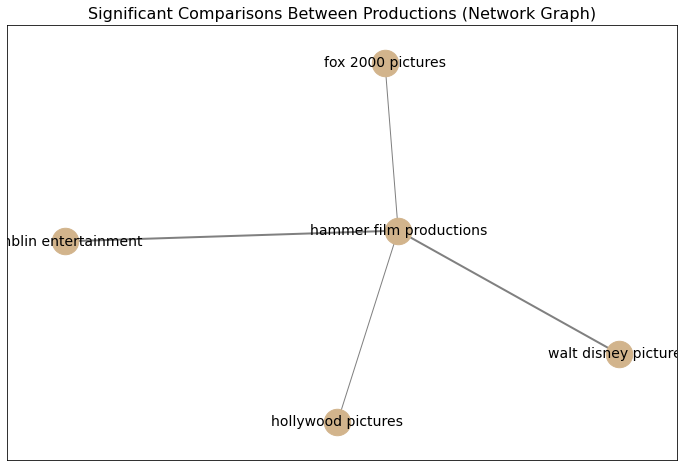

In [21]:


# Loading the dataset
movies = load_dataset(MOVIE_DATASET)
if movies is None:
    raise ValueError("Error while loading the dataset")

# Extracting production names
movies['production_names'] = movies['Production'].apply(extract_production_names)

# Transforming into a long format table
movies_long = movies.explode('production_names')

movies_long['production_names'] = movies_long['production_names'].apply(clean_production_name)

# Filtering valid groups
valid_groups = filter_valid_groups(movies_long, column='production_names')
if valid_groups.empty:
    raise ValueError("No valid groups (size ≥ 3) found for statistical tests.")

# Calculating the average scores per production
production_scores = valid_groups.groupby('production_names')['Score'].mean().reset_index()
production_scores.rename(columns={'Score': 'avg_Score'}, inplace=True)

# Preparing groups for statistical tests
group_prod = valid_groups.groupby('production_names')

# Retrieve the index of Warner Bros productions (in production_scores)
warner_bros_index = group_prod.filter(lambda group: group['production_names'].str.contains("warner bros. cartoons", case=False).any()).index
valid_groups = valid_groups.drop(warner_bros_index)

groups = [group['Score'].values for _, group in group_prod]

# Normality and variance homogeneity tests
normality = test_normality(groups)
homogeneity = test_variance_homogeneity(groups)

# Final statistical test
perform_statistical_test(groups, normality, homogeneity)

# Define a minimum threshold for the number of films per group
min_films_per_group = 50  # For example, at least 50 films per group

# Calculate the size of the groups
group_sizes = valid_groups.groupby('production_names').size()

# Filter groups with at least `min_films_per_group` films
valid_groups = valid_groups[valid_groups['production_names'].isin(group_sizes[group_sizes >= min_films_per_group].index)]

# Create lists for scores and group labels
scores = []
labels = []

# Populate the lists with scores and labels
for production, group in valid_groups.groupby('production_names'):
    scores.extend(group['Score'].values)
    labels.extend([production] * len(group))

# Create a DataFrame with scores and labels
df = pd.DataFrame({
    'score': scores,
    'production_names': labels
})

# Apply Dunn's test with Bonferroni correction for p-values
dunn_results = sp.posthoc_dunn(df, val_col='score', group_col='production_names', p_adjust='bonferroni')

# Filter significant comparisons (p-value < 0.05) and remove NaNs
significant_comparisons = dunn_results[dunn_results < 0.05]

# Remove NaNs from results
significant_comparisons_clean = significant_comparisons.dropna(how='all').dropna(axis=1, how='all')

# Display significant results as "Production 1 vs Production 2: p-value"
print(f"\nSignificant comparisons (p-value < 0.05) for a threshold of {min_films_per_group} movies per production:")


unique_comparisons = set()

# Avoid duplicates (e.g., comparing A with B and B with A)
for row in significant_comparisons_clean.index:
    for col in significant_comparisons_clean.columns:
        if pd.notna(significant_comparisons_clean.loc[row, col]):  # Consider only non-NaN values
            # Create an ordered pair to avoid duplicates
            comparison_pair = tuple(sorted([row, col]))  # Sort names to avoid duplicates like A vs B and B vs A

            # If the pair is not already in the set, add it and print the result
            if comparison_pair not in unique_comparisons:
                unique_comparisons.add(comparison_pair)

                # Calculate the mean scores for each compared production
                mean_row = valid_groups[valid_groups['production_names'] == row]['Score'].mean()
                mean_col = valid_groups[valid_groups['production_names'] == col]['Score'].mean()
                print(f"{row} vs {col}: p-value = {significant_comparisons_clean.loc[row, col]:.5f}, Mean {row} = {mean_row:.2f}, Mean {col} = {mean_col:.2f}")

plot_significant_comparisons(significant_comparisons_clean)

In [22]:


def plot_average_scores_plotly(production_scores):
    fig = px.bar(production_scores,
                 x='production_names',
                 y='avg_Score',
                 title='Average Scores by Production',
                 labels={'production_names': 'Production', 'avg_Score': 'Average Score'},
                 color='production_names')
    fig.update_layout(xaxis_title='Production', yaxis_title='Average Score', xaxis_tickangle=90)
    fig.show()

# Filter productions with more than 20 films and calculate the average scores
valid_groups_filtered = filter_productions_by_size(valid_groups)
production_scores_filtered = valid_groups_filtered.groupby('production_names')['Score'].mean().reset_index()
production_scores_filtered.rename(columns={'Score': 'avg_Score'}, inplace=True)

# Visualization
plot_average_scores_plotly(production_scores_filtered)

def plot_boxplot_scores_plotly(valid_groups):
    fig = px.box(valid_groups,
                 x='production_names',
                 y='Score',
                 title='Score Distribution by Production',
                 labels={'production_names': 'Production', 'Score': 'Score'})
    fig.update_layout(xaxis_title='Production', yaxis_title='Score', xaxis_tickangle=90)
    fig.show()

# Visualization
plot_boxplot_scores_plotly(valid_groups_filtered)


In [51]:

# Function to generate the plots for each combination of thresholds
def generate_all_plots():
    thresholds_min_num = [3, 5, 10]  # List of minimum number of films to consider
    thresholds_min_films = [1, 50, 100]  # List of minimum films count to consider
    
    all_traces = []  # List to store all the plot traces
    buttons = []  # List to store buttons for visibility control
    
    # Loop through each combination of thresholds
    for num_films in thresholds_min_num:
        for min_films in thresholds_min_films:
            # Filter the productions based on the thresholds
            filtered_data = filter_productions_by_size(valid_groups, min_films)
            if filtered_data.empty:
                continue  # Skip if no data after filtering
            
            # Calculate the average scores for each production
            production_scores_filtered = filtered_data.groupby('production_names')['Score'].mean().reset_index()
            production_scores_filtered.rename(columns={'Score': 'avg_Score'}, inplace=True)
            
            # Sort the productions by average score in descending order
            production_scores_sorted = production_scores_filtered.sort_values(by='avg_Score', ascending=False)
            
            # Select the top N and bottom N productions (e.g., top 5 and bottom 5)
            top_n_productions = production_scores_sorted.head(num_films)
            bottom_n_productions = production_scores_sorted.tail(num_films)
            
            # Combine the top and bottom production DataFrames
            combined_productions = pd.concat([top_n_productions, bottom_n_productions])
            
            # Create a bar trace for this plot
            trace = go.Bar(
                x=combined_productions['production_names'],  # X-axis: production names
                y=combined_productions['avg_Score'],  # Y-axis: average score
                name=f"Min Movies: {min_films} - Num Plot : {num_films}",  # Name for the trace
                marker=dict(color=combined_productions['avg_Score'], colorscale=copper_colorscale),  # Color scale based on score
                hoverinfo='x+y'  # Info shown on hover
            )
            all_traces.append(trace)  # Add trace to the list
            
            # Add a button for controlling the visibility of this plot
            visibility = [False] * len(thresholds_min_num) * len(thresholds_min_films)
            idx = thresholds_min_num.index(num_films) * len(thresholds_min_films) + thresholds_min_films.index(min_films)
            visibility[idx] = True
            buttons.append(dict(
                label=f"Min Movies: {min_films} - Num Plot: {num_films}",  # Button label
                method="update",  # Method for updating visibility
                args=[{"visible": visibility}, {"title": f"Productions with a minimum of movies: {min_films} - Top {num_films} Production per score means"}]
            ))
    
    return all_traces, buttons  # Return all traces and buttons for visibility control

# Function to save the interactive HTML file
def save_all_plots_html(output_folder):
    all_traces, buttons = generate_all_plots()  # Generate the traces and buttons
    
    # Create the figure with all the traces
    fig = go.Figure(data=all_traces)
    
    # Update the layout with buttons to control visibility
    fig.update_layout(
        title= "Top and Bottom Productions by Score",  # Title of the plot
        xaxis_title="Name of the Production",  # Label for X-axis
        yaxis_title="Average Score",  # Label for Y-axis
        template="plotly_white",  # Set the template for the plot
        updatemenus=[{
            "buttons": buttons,  # Add the buttons for visibility control
            "direction": "down",  # Direction of the button dropdown
            "x": 1,  # X position of the button
            "xanchor": "right",  # Anchor the button at the center horizontally
            "y": 1.10,  # Y position of the button
            "yanchor": "top",  # Anchor the button at the top vertically
            "showactive": True  # Show active button state
        }],
        #visible=visibility  # Set the visibility control for the plots
    )
    
    # Save the figure to an HTML file
    output_file = os.path.join("productions_plots_new.html")  # Specify the output file path
    pio.write_html(fig, file=output_file, full_html=True, include_plotlyjs="cdn")  # Save the figure as an HTML file
    print(f"HTML saved to: {output_file}")  # Print the saved file location


output_folder = ""  # Remplacez par votre répertoire de sauvegarde
save_all_plots_html(output_folder)

HTML saved to: productions_plots_new.html
